# Gaussian Processes

Gaussian Processes (GPs) are stochastic processes, i.e. collections of random variables, such that every finite collection of random variables has a multivariate normal distribution. 
GPs can be interpreted as **distributions over functions** $f(x)$. In fact, whenever we observe a finite set of values $(f(x_1),\ldots,f(x_N))$, we assume they are jointly normally distributed with some mean $\mu(x)$ and covariance $\Sigma(x)$. Let

$$ f(x) \sim \mathcal{GP}\big(\mu(x), \Sigma(x)\big)$$

denote a Gaussian Process, where for any finite subset $\bar{x}=(x_1,\ldots,x_N)$, the marginal distribution is a multivariate Gaussian $ f(\bar{x})\sim \mathcal{N}\big(\mu(\bar{x}), \Sigma(\bar{x})\big).$

## Kernels

The covariance matrix $\Sigma(x)$ of a GP is defined by a **kernel function** $k$, to ensure that the learned function preserves similarity between the inputs:

$$
\Sigma_{ij}=k(x_i,x_j).
$$


A kernel (or covariance function) $k:\mathcal{X}\times\mathcal{X}\rightarrow \mathbb{R}$ defines the statistical relationship between two variables in a space $\mathcal{X}$. It is symmetric and non-negative 

\begin{align*}
k(x,x')&=k(x',x)\\
k(x,x')&\geq0
\end{align*}

so it acts as a measure of similarity in $\mathcal{X}$ and the resulting matrix $\Sigma(x)$ is always symmetric and positive definite.

The choice of a specific kernel function allows to set a prior distribution over functions. Examples of valid kernels are the **radial basis function** (RBF) kernel

$$
k(x,x')=\sigma^2 \exp \Bigg(-\frac{||x-x'||^2}{2 l^2}\Bigg),
$$

the **polynomial** kernel 

$$
k(x,x')=\sigma^2 (x^T x'+b)^d
$$

and the **periodic** kernel 

$$ k(x,x')=\sigma^2 \exp\Bigg( -\frac{2 \sin^2 (\pi (x-x')/p)}{l^2} \Bigg).
$$

Let's define them in pyro using $\sigma=1, l=1, b=0.5, p=3$.

In [1]:
import torch
import numpy as np 

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process as gp_sklearn

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# pyro kernels
rbf = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.))
polynomial = gp.kernels.Polynomial(input_dim=1, variance=torch.tensor(1.), bias=torch.tensor(.5))
periodic = gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.),
                               period=torch.tensor(3))

Let's now consider 50 equispaced test points in $[-5,5]$. We plot the covariance matrix of each kernel (first column) and take three samples from the multivariate normal distributions on the test points (second column). Notice that $\mu(x)=0$.

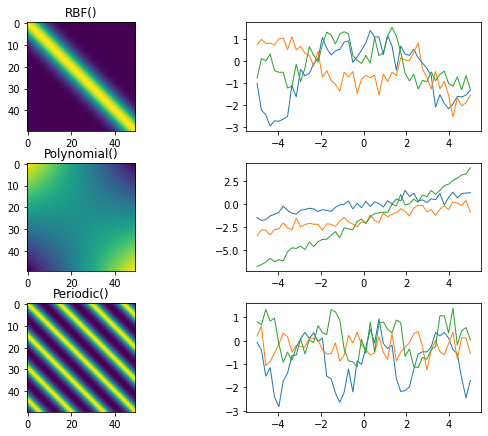

In [3]:
fig, ax = plt.subplots(3, 2, figsize=(8,6))
fig.tight_layout()

# select test points
n_test_points = 50
x_test = torch.linspace(-5, 5, n_test_points)

n_samples=3
for row, kernel in enumerate([rbf, polynomial, periodic]):

    # plot covariance matrix
    ax[row,0].imshow(kernel.forward(x_test, x_test).detach().numpy())
    ax[row,0].set_title(str(kernel), fontsize=12)

    # sample from prior
    mu = torch.zeros(n_test_points)
    K = kernel.forward(x_test, x_test) + (0.4**2) * torch.eye(len(x_test))
    samples = dist.MultivariateNormal(mu, K).sample((n_samples,))

    # plot samples
    for i, sample in enumerate(samples.detach().numpy()):
        ax[row,1].plot(x_test, sample, lw=1)
   
    fig.show()

Kernel functions can also be combined together to generate more complex kernels, by using a set of suitable operations that preserve kernel properties [2, p.296].
For example, we can use products and linear combinations of kernels. 

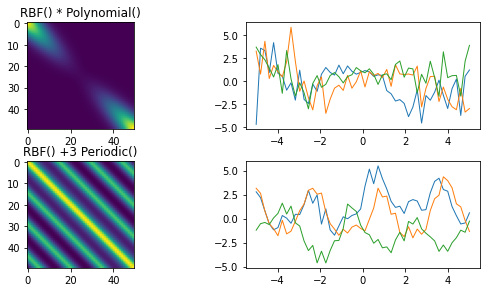

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(8,4))
fig.tight_layout()

### RBF * Polynomial ###

# covariance matrix
ax[0,0].imshow((rbf.forward(x_test, x_test)*polynomial.forward(x_test, x_test)).detach().numpy())
ax[0,0].set_title(str(rbf) + " * " + str(polynomial), fontsize=12)

# samples
K = rbf.forward(x_test, x_test) +(0.4**2) * torch.eye(len(x_test)) * \
    polynomial.forward(x_test, x_test) +(0.4**2) * torch.eye(len(x_test))
samples = dist.MultivariateNormal(mu, K).sample((n_samples,))
for i, sample in enumerate(samples.detach().numpy()):
    ax[0,1].plot(x_test, sample, lw=1)

### RBF + 3 * Periodic ###

# covariance matrix
ax[1,0].imshow((rbf.forward(x_test, x_test)+3*periodic.forward(x_test, x_test)).detach().numpy())
ax[1,0].set_title( str(rbf) + " +3 " + str(periodic), fontsize=12)

# samples
K = rbf.forward(x_test, x_test) +(0.4**2) * torch.eye(len(x_test)) + \
    3*periodic.forward(x_test, x_test) +(0.4**2) * torch.eye(len(x_test))
samples = dist.MultivariateNormal(mu, K).sample((n_samples,))
for i, sample in enumerate(samples.detach().numpy()):
    ax[1,1].plot(x_test, sample, lw=1)

fig.show()

## GP regression

We want to model a dependent variable $y$ as a function of an independent variable $x$, using a set of observations $D=\{(x_i,y_i)\}_i$. 

Classical Bayesian regression fits a parametric function $f(\theta,\cdot)$ to the data, i.e. it infers a probability distribution $f(\theta|D)$. Rather than learning single point estimates of $\theta$, it places a prior over parameters and updates the distribution whenever new data points are observed.

GPs, instead, have a **non-parametric** approach that infers a distribution $p(f|D)$ over all possible functions $f$. 

### Noise-free observations

Consider a 1-dimensional GP with mean $\mu=\mathbf{0}$ and an RBF kernel with $\sigma=1$ and $l=0.2$.

Given a test set $X_*=x_1,\ldots,x_N$, we want to predict the outputs $f_*=(f(x_1),\ldots,f(x_N))$.
Before observing any training data, we can sample from the prior distribution on $X_*$

$$
f_*\sim\mathcal{N}(\mathbf{0},K_{**}),
$$

where $K_{**}=k(X_*, X_*)$.


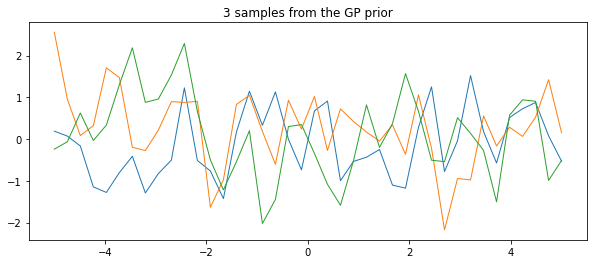

In [5]:
figsize=(10,4)

# select test points
n_test_points=40
x_test = torch.linspace(-5, 5, n_test_points)

# set prior distribution
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(.2))
mu = torch.zeros(n_test_points)
K_ss = kernel.forward(x_test, x_test)

# sample
n_samples=3
prior_samples = dist.MultivariateNormal(mu, K_ss).sample((n_samples,))

# plot
plt.figure(figsize=figsize)
for i, sample in enumerate(prior_samples.detach().numpy()):
    plt.plot(x_test, sample, lw=1,label=f'sample {i}')
plt.title(f'{n_samples} samples from the GP prior')
plt.show()

Suppose we observe a training set $X=\{(x_i, y_i)\}_i$, where the values of $y_i=f(x_i)$ are exact (i.e. non-noisy). The joint distribution on training and test points has the following form

$$
\binom{f}{f_*} \sim \mathcal{N} \Bigg(\binom{\mu}{\mu_*} , 
\begin{pmatrix} K & K_* \\ K_*^T & K_{**} \end{pmatrix}  \Bigg),
$$

where $K=k(X,X)$ and $K_*=k(X,X_*)$.


Now we can condition on $X$ and obtain the posterior [1, p.517]

\begin{align*}
f_*|X_*,X,f &\sim \mathcal{N}(\mu_*,\Sigma_*)\\
\mu_* &= \mu(X_*) + K_*^T K^{-1} (f-\mu(X))\\
\Sigma_* &= K_{**}-K_*^T K^{-1} K_*.
\end{align*}


We now implement the posterior predictive distribution and plot a few posterior samples.

The training data consists of $4$ points $y=\sin(x)$ with $x\in[-4,-2,1,4]$.

In [6]:
def posterior_predictive(x_train, y_train, x_test, kernel, noise_var=None):
    
    # marginal covariance matrices
    K = kernel.forward(x_train, x_train)
    K_s = kernel.forward(x_train, x_test)
    K_ss = kernel.forward(x_test, x_test)
    
    # noise term
    if noise_var is not None:
        K += (noise_var**2) * torch.eye(len(x_train))
    
    # posterior mean and covariance
    mu = torch.mv(K_s.T, torch.mv(K.inverse(), y_train))
    sigma = K_ss - torch.mm(K_s.T, torch.mm(K.inverse(), K_s))
    
    return mu.reshape(-1), sigma

# noiseless training data
x_train = torch.FloatTensor([-4, -2, 1, 4])
y_train = torch.sin(x_train)

# sample from posterior
mu, sigma = posterior_predictive(x_train, y_train, x_test, kernel)
posterior_samples = dist.MultivariateNormal(mu, sigma).sample((n_samples,))

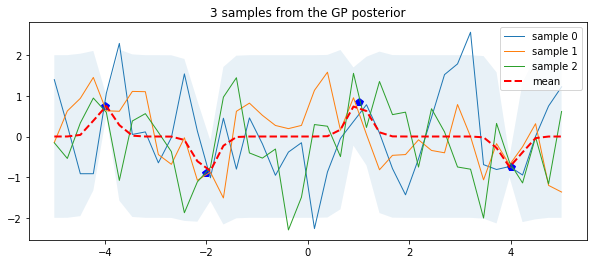

In [7]:
def plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples=None, stdv_scale=2):
    plt.figure(figsize=figsize)

    # detach tensors
    x_train = x_train.detach().numpy()
    x_test = x_test.detach().numpy()
    mu = mu.detach().numpy()

    # training points
    plt.plot(x_train, y_train, 'bp', ms=8)
    
    # posterior samples
    if posterior_samples is not None:
        plt.title(f'{len(posterior_samples)} samples from the GP posterior')
        
        for i, sample in enumerate(posterior_samples):
            plt.plot(x_test, sample, lw=1, label=f'sample {i}')

    # posterior mean
    plt.plot(x_test, mu, 'r--', lw=2, label="mean")
    
    # standard deviation
    stdv = stdv_scale * sigma.diag().sqrt().detach().numpy()
    plt.fill_between(x_test, mu-stdv, mu+stdv, alpha=0.1)
    
    plt.legend()
    plt.show()
    
plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples.detach().numpy())

Notice that since the observations are noiseless, the GP acts as an **interpolator** of the training data.


### Noisy observations

Now suppose that the observations are noisy 
$$y_i=f(x_i)+\epsilon \qquad \epsilon \sim\mathcal{N}(0, \sigma^2).$$

In this case, the model cannot interpolate the training points, but only get closer to them after conditing.

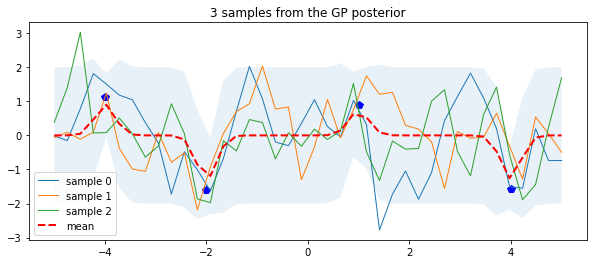

In [8]:
# noisy training data
noise_var = 0.5
noise = noise_var * dist.Normal(0, 1).sample((4,))
y_train = torch.sin(x_train) + noise

# sample from posterior
mu, sigma = posterior_predictive(x_train, y_train, x_test, kernel, noise_var)
posterior_samples = dist.MultivariateNormal(mu, sigma).sample((n_samples,))
plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples.detach().numpy())

By changing the kernel hyperparameters we could obtain a significantly different fit to the data.

kernel_var=0.3, kernel_ls=0.2, noise_var=0.5


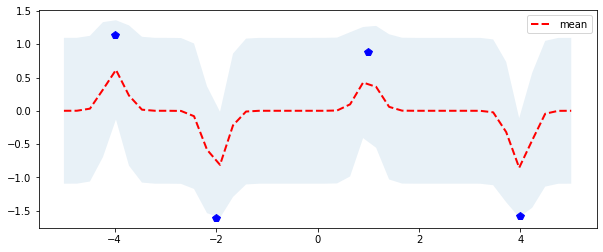

kernel_var=1.0, kernel_ls=0.5, noise_var=0.5


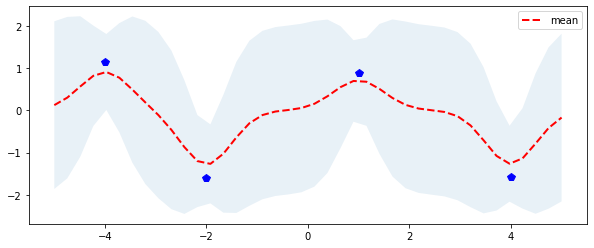

In [9]:
params = [(0.3, 0.2), (1., 0.5)]

for kernel_var, kernel_ls in params:
    
    kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(kernel_var), lengthscale=torch.tensor(kernel_ls))
    mu, sigma = posterior_predictive(x_train, y_train, x_test, kernel, noise_var)
    print(f"kernel_var={kernel_var}, kernel_ls={kernel_ls}, noise_var={noise_var}")
    plot_posterior_distr(x_train, x_test, mu, sigma)

## Learn kernel parameters 

Instead of arbitrarily choosing the kernel hyperparameters, we could infer them directly from the observed data.

### Scikit-learn MLE

`GaussianProcessRegressor` from scikit-learn library optimizes the kernel hyperparameters $\theta$ by maximizing the marginal log-likelihood $ p(y| x,\theta)$ on the observed data $(x,y)$

$$
\hat{\theta} = \text{argmax}_\theta p(y| x,\theta).
$$

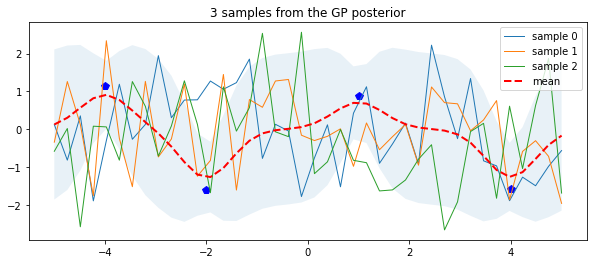

In [10]:
# set kernel and GP
kernel_sklearn = gp_sklearn.kernels.RBF(length_scale=1.0)
gpr_sklearn = GaussianProcessRegressor(kernel_sklearn)

# fit GP to the observed data
gpr_sklearn.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))

# sample from posterior
posterior_samples = gpr_sklearn.sample_y(x_test.reshape(-1, 1), n_samples=n_samples)
posterior_samples = posterior_samples.reshape(n_samples, len(x_test))
plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples)

### Pyro HMC inference

Pyro `gp.models.GPRegression` class allows to perform approximate inference on the kernel parameters.  Let's look at an example with HMC algorithm.

In [11]:
pyro.clear_param_store()

# set kernel and GP
kernel = gp.kernels.RBF(input_dim=1)
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(noise_var))

# set priors and run HMC
gpr.kernel.set_prior("variance", dist.Exponential(1))
gpr.kernel.set_prior("lengthscale", dist.Normal(0., 0.5))

hmc_kernel = HMC(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=30, warmup_steps=200)
mcmc.run()

Sample: 100%|██████████| 230/230 [00:08, 27.70it/s, step size=5.18e-01, acc. prob=0.995]


Now we sample from the posterior distribution, using the learned parameters. 

Posterior variance = 0.8998116254806519 
Posterior lengthscale = 0.08697617799043655


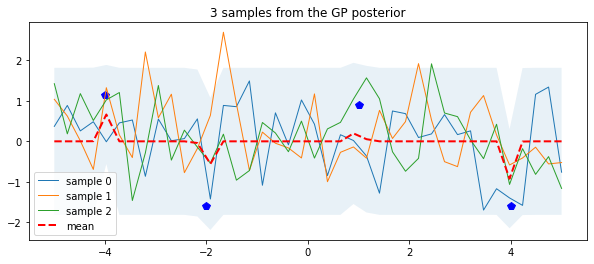

In [12]:
# update kernel parameters
kernel_var = mcmc.get_samples()['kernel.variance'].mean()
kernel_ls = mcmc.get_samples()['kernel.lengthscale'].mean()
kernel = gp.kernels.RBF(input_dim=1, variance=kernel_var, lengthscale=kernel_ls)

print("Posterior variance =", kernel_var.item(), "\nPosterior lengthscale =", kernel_ls.item())

# sample from posterior
mu, sigma = gpr(x_test, full_cov=True)
posterior_samples = dist.MultivariateNormal(mu, sigma).sample((n_samples,)) 
plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples)

## References
[1] K. P. Murphy, "Machine Learning: A Probabilistic Perspective", Chap. 15

[2] C. M. Bishop, "Pattern Recognition and Machine Learning", Chap. 6

[3] [Pyro GPs documentation](https://pyro.ai/examples/gp.html)

[4] [SKlearn GPs documentation](https://scikit-learn.org/stable/modules/gaussian_process.html)